In [1]:
from ete3 import Tree, TreeStyle
import os
import pickle
from collections import Counter

import sys

sys.path.append("/groups/itay_mayrose/halabikeren/tmp/ploidb/data_processing/")
from check_tree_monophyly import add_group_by_property

import pandas as pd
import numpy as np
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=False)

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

pallete = px.colors.qualitative.Vivid
import plotly.io as pio

pio.templates.default = "plotly_white"

import matplotlib.pyplot as plt
import seaborn as sns

fontsize = 24
plt.rcParams.update({"font.size": fontsize, "font.weight": "normal", "axes.grid": False, "savefig.transparent": False})
sns.set_style("white")
colors = ["#377eb8", "#ff7f00", "#4daf4a", "#f781bf", "#a65628", "#984ea3", "#999999", "#e41a1c", "#dede00"]

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:

def process_tree(tree_path: str, group_by: str, classification_data: pd.DataFrame) -> Tree:
    tree = Tree(tree_path, format=1)
    add_group_by_property(tree=tree, class_name=group_by, classification_data=classification_data)
    return tree


def process_tree_data(data_path: str, tree: Tree, group_by: str, classification_data: pd.DataFrame) -> pd.DataFrame:
    mono_analysis = pd.read_csv(data_path)
    groups_counter = Counter([leaf.__dict__[group_by] for leaf in tree.get_leaves()])
    mono_analysis["num_species"] = mono_analysis.parallel_apply(lambda record: groups_counter[record[group_by]], axis=1)
    return mono_analysis


def process_data(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["score"] = (df["total_members_coverage"] + df["subtree_members_coverage"]) / 2.0
    return df


In [3]:
group_by_options = ["genus", "family"]
include_missing_data = False
tree_name = "ALLMB"  # or "ALLOTB"
add_missing_names = True
classification_path = "../trees/wfo_classification_data.csv"
tree_path = f"../trees/resolved_{tree_name}_name_resolution_on_none_with_added_ccdb_{'and_wo_counts_' if add_missing_names else ''}names.nwk"
classification_data = pd.read_csv(classification_path)

In [4]:
group_by_to_mono_analysis = dict()
group_by_to_scores = dict()
group_by_to_mrca_scores = dict()
group_by_to_optimal_scores = dict()
for group_by in group_by_options:
    print(f"grouping by {group_by}")
    monophyly_path = (
        f"../trees/analysis_on_tree_with_added_ccdb_names/{tree_name}_{group_by}wise_monophyly_analysis.csv"
    )
    scores_analysis_dir = f"../trees/analysis_on_tree_with_added_ccdb_names/{tree_name}_{group_by}wise_monophyly_analysis/monophyly_status/"
    scores_analysis_path = f"../trees//{tree_name}_{group_by}wise_monophyly_analysis.pkl"

    print(f"processing {tree_name} tree and data")
    tree = process_tree(tree_path=tree_path, group_by=group_by, classification_data=classification_data)
    mono_analysis = process_tree_data(
        monophyly_path, tree=tree, group_by=group_by, classification_data=classification_data
    )
    group_by_to_mono_analysis[group_by] = mono_analysis
    print(
        f"% paraphyly across {group_by} records in {tree_name} tree = {np.round(mono_analysis.loc[mono_analysis.is_monophyletic == False].shape[0] / mono_analysis.shape[0] * 100)}%"
    )

    if os.path.exists(scores_analysis_path):
        with open(scores_analysis_path, "rb") as infile:
            scores_analysis = pickle.load(file=infile)
    else:
        scores_analysis = {
            path.replace(f"{group_by}_", "").replace("_ancestry_stats.csv", ""): process_data(
                f"{scores_analysis_dir}{path}"
            )
            for path in os.listdir(scores_analysis_dir)
            if path.endswith("_ancestry_stats.csv")
        }
        group_by_to_scores[group_by] = scores_analysis
        with open(scores_analysis_path, "wb") as outfile:
            pickle.dump(obj=scores_analysis, file=outfile)

    mrca_scores = pd.DataFrame()
    optimal_scores = pd.DataFrame()
    for group in scores_analysis:

        data = scores_analysis[group].loc[scores_analysis[group].total_members_coverage == 1].copy()
        data[group_by] = group
        mrca_scores = pd.concat([mrca_scores, data])

        data = scores_analysis[group].loc[scores_analysis[group].score == scores_analysis[group].score.max()].copy()
        data[group_by] = group
        optimal_scores = pd.concat([optimal_scores, data])

    mrca_scores.drop_duplicates([group_by], keep="first", inplace=True)
    optimal_scores.drop_duplicates([group_by], keep="first", inplace=True)
    group_to_size = mono_analysis.set_index(group_by)["num_species"].to_dict()
    mrca_scores[f"{group_by}_size"] = mrca_scores[group_by].apply(lambda f: group_to_size.get(f, np.nan))
    optimal_scores[f"{group_by}_size"] = optimal_scores[group_by].apply(lambda f: group_to_size.get(f, np.nan))
    group_by_to_mrca_scores[group_by] = mrca_scores
    group_by_to_optimal_scores[group_by] = optimal_scores

grouping by genus
processing ALLMB tree and data
% paraphyly across genus records in ALLMB tree = 16.0%
grouping by family
processing ALLMB tree and data
% paraphyly across family records in ALLMB tree = 37.0%


In [18]:
group_by_to_mrca_scores["genus"].loc[group_by_to_mrca_scores["genus"].score < 1]

,node,num_members,size_subtree,total_members_coverage,subtree_members_coverage,score,genus,genus_size
0,N2554,2,4,1.0,0.500000,0.750000,schelhammera,2
0,Lindernia,17,19,1.0,0.894737,0.947368,lindernia,70
0,N48822,4,5,1.0,0.800000,0.900000,lessertia,55
0,N77917,4,27,1.0,0.148148,0.574074,hyalolaena,6
0,N53028,296,316,1.0,0.936709,0.968354,festuca,786
...,...,...,...,...,...,...,...,...
0,NaN,3,70334,1.0,0.000043,0.500021,aethusa,3
0,NaN,7,70334,1.0,0.000100,0.500050,kochia,9
0,NaN,2,70334,1.0,0.000028,0.500014,ventenata,8
0,NaN,2,70334,1.0,0.000028,0.500014,ammoselinum,4


In [19]:
genus_dir = "../chromevol/with_model_weighting/by_genus_on_unresolved_ALLMB_and_unresolved_ccdb/"
family_dir = "../chromevol/with_model_weighting/by_family_on_unresolved_ALLMB_and_unresolved_ccdb/"
run_genera = [p for p in os.listdir(genus_dir) if os.path.exists(f"{genus_dir}{p}/chromevol.out")]
run_families = [p for p in os.listdir(family_dir) if os.path.exists(f"{family_dir}{p}/chromevol.out")]

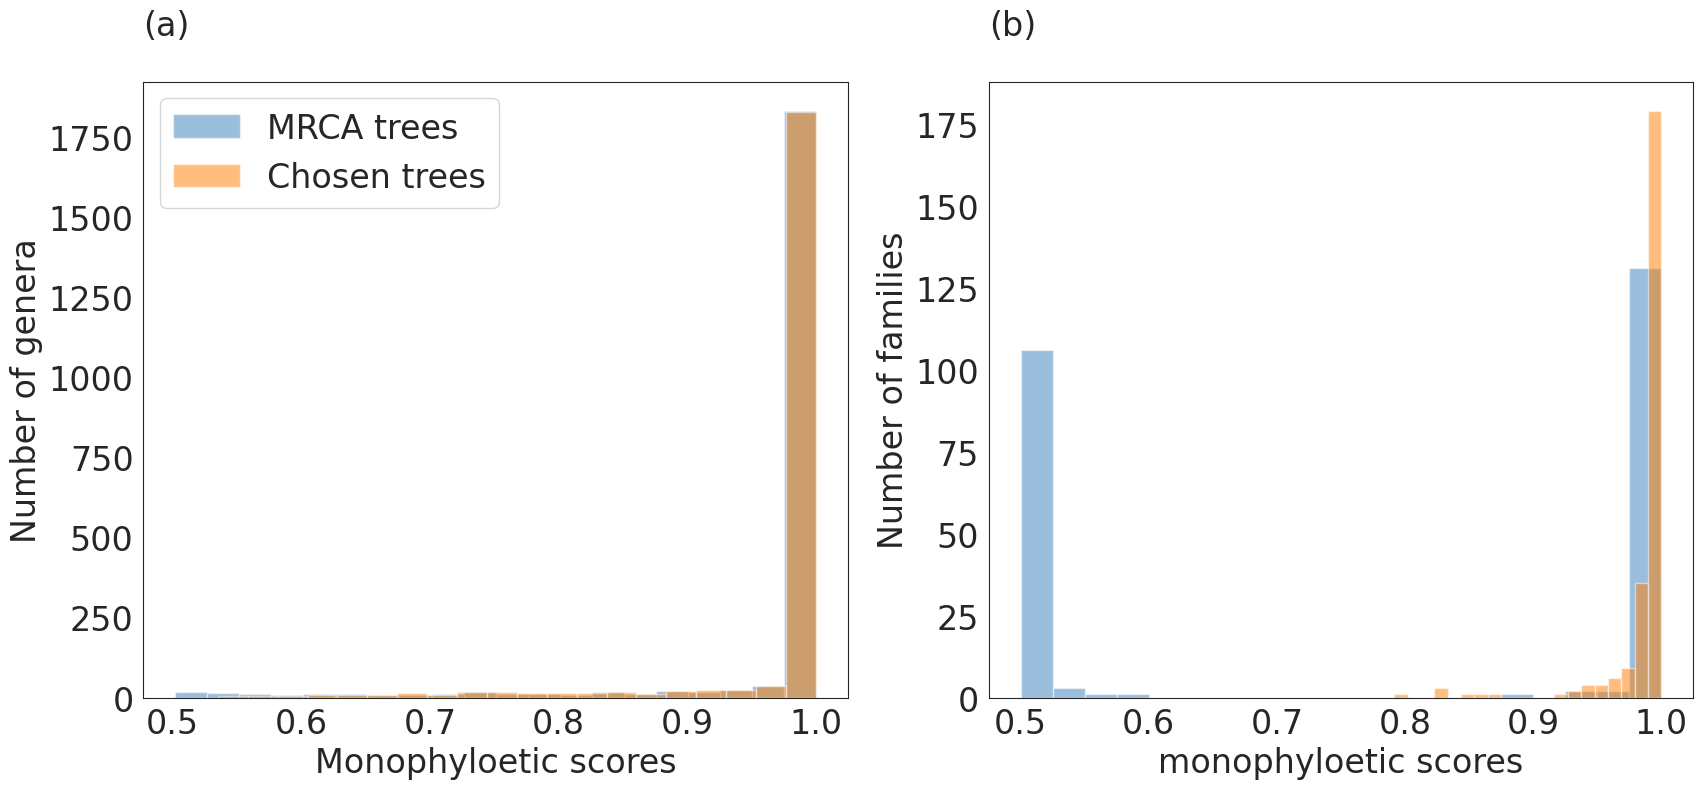

In [20]:
import matplotlib.pyplot as plt

fontsize = 24
plt.rcParams.update({"font.size": fontsize, "font.weight": "normal", "axes.grid": False, "savefig.transparent": False})
colors = ["#377eb8", "#ff7f00", "#4daf4a", "#f781bf", "#a65628", "#984ea3", "#999999", "#e41a1c", "#dede00"]


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

ax = axes[0]
ax.hist(
    group_by_to_mrca_scores["genus"].loc[group_by_to_mrca_scores["genus"].genus.isin(run_genera)].score,
    color=colors[0],
    alpha=0.5,
    label="MRCA trees",
    bins=20,
)
ax.hist(
    group_by_to_optimal_scores["genus"].loc[group_by_to_optimal_scores["genus"].genus.isin(run_genera)].score,
    color=colors[1],
    alpha=0.5,
    label="Chosen trees",
    bins=20,
)
ax.set_xlabel("Monophyloetic scores", fontsize=fontsize)
ax.set_ylabel("Number of genera", fontsize=fontsize)
ax.legend()
ax.set_title("(a)\n", loc="left", fontsize=fontsize)

ax = axes[1]
ax.hist(
    group_by_to_mrca_scores["family"].loc[group_by_to_mrca_scores["family"].family.isin(run_families)].score,
    color=colors[0],
    alpha=0.5,
    label="MRCA trees",
    bins=20,
)
ax.hist(
    group_by_to_optimal_scores["family"].loc[group_by_to_optimal_scores["family"].family.isin(run_families)].score,
    color=colors[1],
    alpha=0.5,
    label="Chosen trees",
    bins=20,
)
ax.set_xlabel("monophyloetic scores", fontsize=fontsize)
ax.set_ylabel("Number of families", fontsize=fontsize)
ax.set_title("(b)\n", loc="left", fontsize=fontsize)

fig.savefig("Fig S4.jpeg")

In [6]:
group_by_to_mono_analysis["genus"][["genus", "largest_monophyletic_fraction"]]

,genus,largest_monophyletic_fraction
0,piptospatha,1.000000
1,archontophoenix,1.000000
2,kalopanax,1.000000
3,hexacyrtis,1.000000
4,przewalskia,1.000000
...,...,...
6682,lantana,0.166667
6683,steganotaenia,1.000000
6684,rigiopappus,1.000000
6685,anredera,1.000000


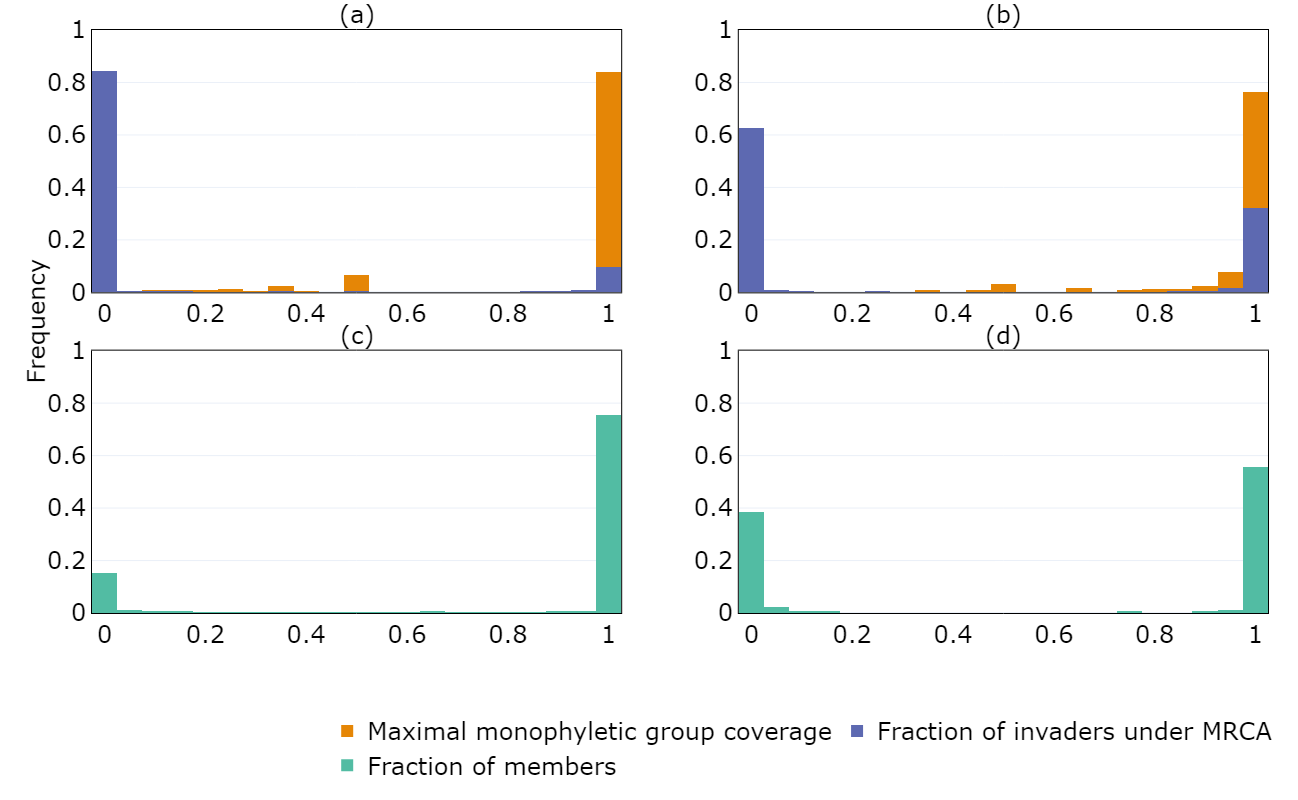

In [9]:
fig = make_subplots(
    rows=2,
    cols=2,
    subplot_titles=["(a)", "(b)", "(c)", "(d)"],
    y_title="Frequency",
    horizontal_spacing=0.1,
    vertical_spacing=0.1,
)
fig.update_annotations(font_size=fontsize)

fig.add_trace(
    go.Histogram(
        x=group_by_to_mono_analysis["genus"]["largest_monophyletic_fraction"],
        histnorm="probability",
        marker_color=pallete[0],
        nbinsx=20,
        name="Maximal monophyletic group coverage",
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Histogram(
        x=group_by_to_mono_analysis["genus"]["fraction_of_invaders"],
        histnorm="probability",
        marker_color=pallete[1],
        nbinsx=20,
        name="Fraction of invaders under MRCA",
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Histogram(
        x=group_by_to_mono_analysis["family"]["largest_monophyletic_fraction"],
        histnorm="probability",
        marker_color=pallete[0],
        nbinsx=20,
        showlegend=False,
    ),
    row=1,
    col=2,
)
fig.add_trace(
    go.Histogram(
        x=group_by_to_mono_analysis["family"]["fraction_of_invaders"],
        histnorm="probability",
        marker_color=pallete[1],
        nbinsx=20,
        showlegend=False,
    ),
    row=1,
    col=2,
)


fig.add_trace(
    go.Histogram(
        x=group_by_to_mrca_scores["genus"]["subtree_members_coverage"],
        histnorm="probability",
        marker_color=pallete[2],
        nbinsx=20,
        name="Fraction of members",
    ),
    row=2,
    col=1,
)

fig.add_trace(
    go.Histogram(
        x=group_by_to_mrca_scores["family"]["subtree_members_coverage"],
        histnorm="probability",
        marker_color=pallete[2],
        nbinsx=20,
        showlegend=False,
    ),
    row=2,
    col=2,
)

fig.update_yaxes(
    title_text="", nticks=10, range=[0, 1], showline=True, linewidth=1, linecolor="black", mirror="all"
)  # only once, yticks more dense, all scale 0-1
fig.update_xaxes(showline=True, linewidth=1, linecolor="black", mirror=True)

fig.update_layout(
    barmode="overlay",
    width=1000,
    height=800,
    font_color="black",
    title_font_family="Ariel",
    yaxis_range=[0, 1],
    legend=dict(yanchor="bottom", y=-0.3, x=0.2),
    legend_orientation="h",
    margin=dict(l=30, r=30, t=30, b=30),
    font_size=fontsize
    # title=f"{group_by}-partition based trees MRCA scores",
)


fig.update_traces(opacity=0.8, marker_size=12, marker_line=dict(width=2, color="black"), selector=dict(mode="markers"))
fig.show()

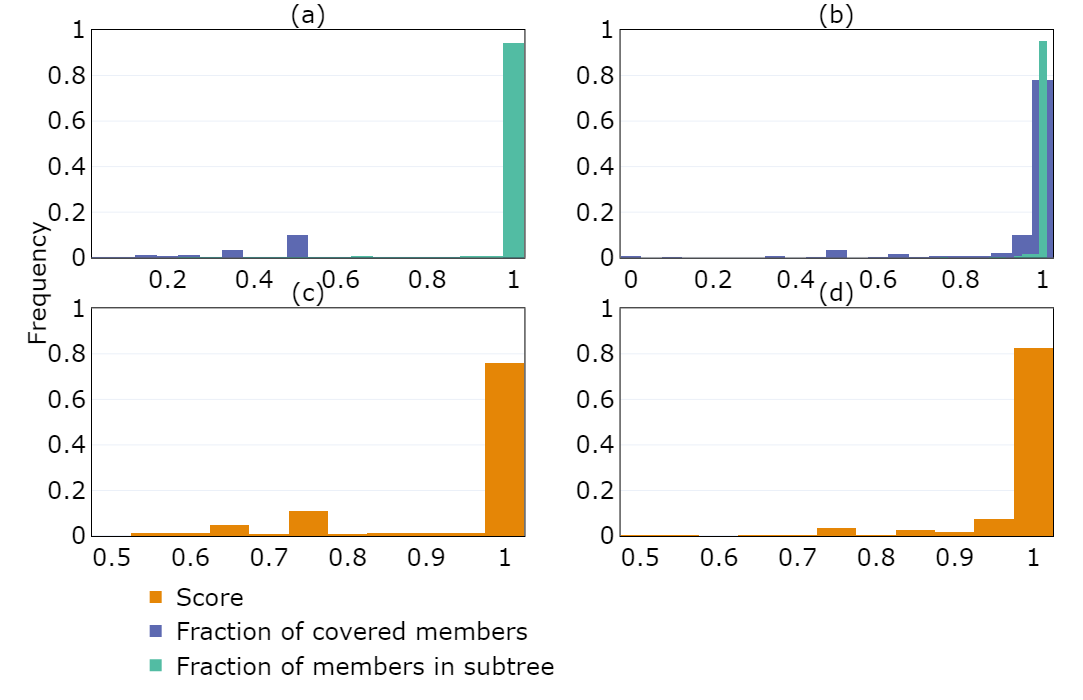

In [26]:
fig = make_subplots(
    rows=2,
    cols=2,
    subplot_titles=["(a)", "(b)", "(c)", "(d)"],
    y_title="Frequency",
    horizontal_spacing=0.1,
    vertical_spacing=0.1,
)
fig.update_annotations(font_size=fontsize)

fig.add_trace(
    go.Histogram(
        x=group_by_to_optimal_scores["genus"]["score"],
        histnorm="probability",
        marker_color=pallete[0],
        nbinsx=20,
        name="Score",
    ),
    row=2,
    col=1,
)

fig.add_trace(
    go.Histogram(
        x=group_by_to_optimal_scores["genus"]["total_members_coverage"],
        histnorm="probability",
        marker_color=pallete[1],
        nbinsx=20,
        name="Fraction of covered members",
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Histogram(
        x=group_by_to_optimal_scores["genus"]["subtree_members_coverage"],
        histnorm="probability",
        marker_color=pallete[2],
        nbinsx=20,
        name="Fraction of members in subtree",
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Histogram(
        x=group_by_to_optimal_scores["family"]["score"],
        histnorm="probability",
        marker_color=pallete[0],
        nbinsx=20,
        showlegend=False,
    ),
    row=2,
    col=2,
)

fig.add_trace(
    go.Histogram(
        x=group_by_to_optimal_scores["family"]["total_members_coverage"],
        histnorm="probability",
        marker_color=pallete[1],
        nbinsx=20,
        showlegend=False,
    ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Histogram(
        x=group_by_to_optimal_scores["family"]["subtree_members_coverage"],
        histnorm="probability",
        marker_color=pallete[2],
        nbinsx=20,
        showlegend=False,
    ),
    row=1,
    col=2,
)

fig.update_yaxes(
    title_text="", nticks=10, range=[0, 1], showline=True, linewidth=1, linecolor="black", mirror="all"
)  # only once, yticks more dense, all scale 0-1
fig.update_xaxes(showline=True, linewidth=1, linecolor="black", mirror=True)

fig.update_layout(
    barmode="overlay",
    width=1000,
    height=700,
    font_color="black",
    title_font_family="Ariel",
    yaxis_range=[0, 1],
    legend=dict(yanchor="bottom", y=-0.3, x=0.56),
    legend_orientation="h",
    margin=dict(l=30, r=30, t=30, b=30),
    font_size=fontsize,
)
fig.update_traces(opacity=0.8, marker_size=12, marker_line=dict(width=2, color="black"), selector=dict(mode="markers"))
fig.show()

In [14]:
for group_by in group_by_options:
    print(
        f"\n% {group_by} records in which the mrca is tree root = {np.round(group_by_to_mrca_scores[group_by].loc[group_by_to_mrca_scores[group_by].node.isna()].shape[0]/group_by_to_mrca_scores[group_by].shape[0]*100,3)}%"
    )
    print(
        f"% {group_by} records in which the optimal root is tree root = {group_by_to_optimal_scores[group_by].loc[group_by_to_optimal_scores[group_by].node.isna()].shape[0]/group_by_to_optimal_scores[group_by].shape[0]*100}%"
    )
    print(
        f"# {group_by} records lost due to choice of optimal root = {group_by_to_optimal_scores[group_by].loc[(group_by_to_optimal_scores[group_by].size_subtree <= 5)].shape[0]:,}"
    )


% genus records in which the mrca is tree root = 0.0%
% genus records in which the optimal root is tree root = 0.0%
# genus records lost due to choice of optimal root = 1,161

% family records in which the mrca is tree root = 24.251%
% family records in which the optimal root is tree root = 0.0%
# family records lost due to choice of optimal root = 76


In [15]:
# save the optimal root per feamily and partition based on it
for group_by in group_by_options:
    group_by_to_optimal_scores[group_by].to_csv(
        f"./optimal_{tree_name}_roots_for_{group_by}_partition.csv", index=False
    )

# Cherry-picking analysis

In [16]:
mrca_data = group_by_to_mrca_scores["family"].sort_values(["score", "size_subtree"], ascending=[True, True])
bad_families = mrca_data.loc[(mrca_data.score < 1) & (mrca_data.node.notna())].iloc[:3].sort_values("family")
good_families = mrca_data.loc[(mrca_data.score < 1) & (mrca_data.node.notna())].iloc[-3:].sort_values("family")

In [17]:
optimal_data = group_by_to_optimal_scores["family"].sort_values(["score", "size_subtree"], ascending=[True, True])
optimals_for_bad_families = optimal_data.loc[optimal_data.family.isin(bad_families.family)].sort_values("family")
optimals_for_good_families = optimal_data.loc[optimal_data.family.isin(good_families.family)].sort_values("family")

In [18]:
optimal_data.sort_values("score").head()

,node,num_members,size_subtree,total_members_coverage,subtree_members_coverage,score,family,family_size
9,orbivestus blumeoidea,1,1,0.005988,1.0,0.502994,compositae,167
15,laburnocytisus adamii,1,1,0.010638,1.0,0.505319,leguminosae,94
406,dischidia apoensis,1,1,0.035714,1.0,0.517857,asclepiadaceae,28
395,eremurus albertii,1,1,0.100000,1.0,0.550000,xanthorrhoeaceae,10
20,scabiosa anethifolia,1,1,0.125000,1.0,0.562500,dipsacaceae,8


In [19]:
optimals_for_bad_families

,node,num_members,size_subtree,total_members_coverage,subtree_members_coverage,score,family,family_size
669,aphloia theiformis,1,1,0.500000,1.000000,0.750000,aphloiaceae,2
539,acacia deanei subsp. deanei,1,1,0.500000,1.000000,0.750000,mimosaceae,2
231,N1409,32,36,0.666667,0.888889,0.777778,olacaceae,48


In [20]:
optimals_for_good_families

,node,num_members,size_subtree,total_members_coverage,subtree_members_coverage,score,family,family_size
0,N2940,39,40,1.0,0.975000,0.987500,icacinaceae,39
0,N7371,100,102,1.0,0.980392,0.990196,resedaceae,100
0,N3400,138,141,1.0,0.978723,0.989362,vochysiaceae,138


In [88]:

def show_tree_by_members(
    full_tree: tree,
    group_name: str,
    group_to_mrca: pd.DataFrame,
    classification_data: pd.DataFrame,
    group_type: str = "family",
):
    group_tree = full_tree.search_nodes(
        name=group_to_mrca.loc[group_to_mrca[group_type] == group_name, "node"].values[0]
    )[0].copy()
    members = set(classification_data.loc[classification_data[group_type] == group_name].taxon.tolist())
    for leaf in group_tree.get_leaves():
        if leaf.name in members:
            leaf.name = f"1_{leaf.name}"
        else:
            leaf.name = f"0_{leaf.name}"
    print(group_tree)


# Determine time points to partition by

In [21]:
tree = Tree(tree_path, format=1)
group_by_to_optimal_roots_time = dict()
for group_by in group_by_options:
    optimal_internal_nodes_names = group_by_to_optimal_scores[group_by].node.tolist()
    group_by_to_optimal_roots_time[group_by] = [
        tree.get_distance(node_name) if node_name != "N0" else 0 for node_name in optimal_internal_nodes_names
    ]

<AxesSubplot:>

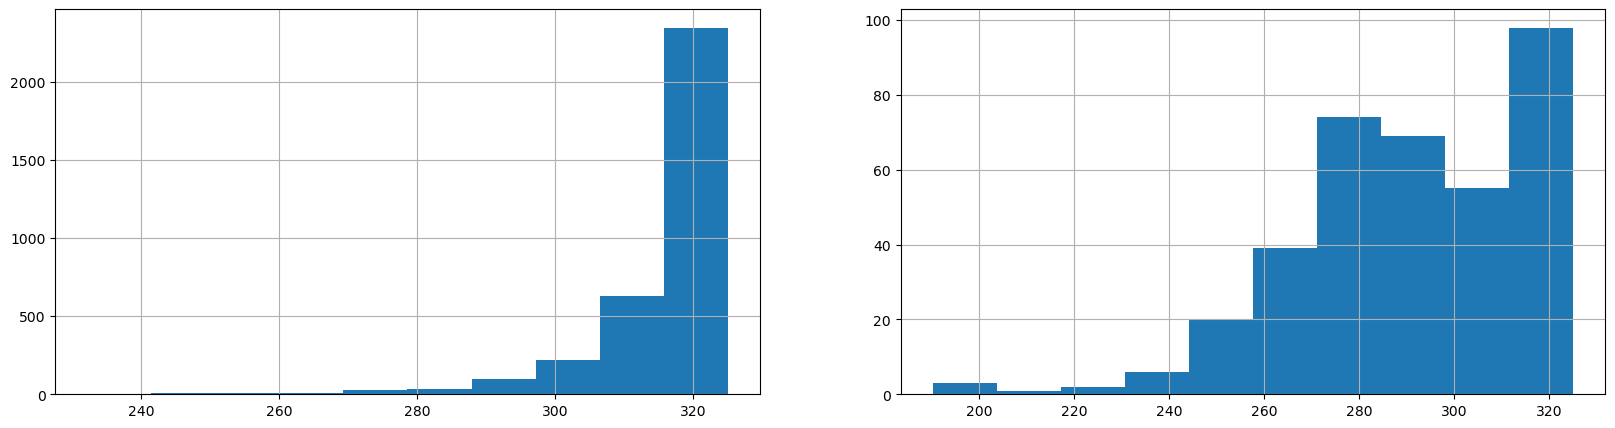

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
pd.Series(group_by_to_optimal_roots_time["genus"]).hist(
    ax=ax[0],
    label="genus",
)
pd.Series(group_by_to_optimal_roots_time["family"]).hist(ax=ax[1], label="family")

In [23]:
pd.Series(group_by_to_optimal_roots_time["family"]).median()

292.95601600000003

In [24]:
pd.Series(group_by_to_optimal_roots_time["genus"]).median()

319.803506

In [4]:
from ete3 import Tree

main_tree = Tree(tree_path, format=1)
root_age = main_tree.get_distance(main_tree.get_leaves()[0])
root_age

325.050124

In [5]:
root_age - 319.803506

5.246617999999955

In [6]:
root_age - 292.95601600000003

32.09410799999995